In [ ]:
import numpy as np
import torch
from torch.distributions.normal import Normal


class StableNormal(Normal):
    """
    Add stable cdf for implicit reparametrization, and stable _log_cdf.
    """
    
    # Override default
    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return ndtr(self._standardise(value))
    
    # NOTE: This is not necessary for implicit reparam.
    def _log_cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return log_ndtr(self._standardise(value))
    
    def _standardise(self, x):
        return (x - self.loc) * self.scale.reciprocal()

#
# Below are based on the investigation in https://github.com/pytorch/pytorch/issues/52973#issuecomment-787587188
# and implementations in SciPy and Tensorflow Probability
#

def ndtr(value: torch.Tensor):
    """
    Standard Gaussian cumulative distribution function.
    Based on the SciPy implementation of ndtr
    https://github.com/scipy/scipy/blob/master/scipy/special/cephes/ndtr.c#L201-L224
    """
    sqrt_half = torch.sqrt(torch.tensor(0.5, dtype=value.dtype))
    x = value * sqrt_half
    z = torch.abs(x)
    y = 0.5 * torch.erfc(z)
    output = torch.where(z < sqrt_half,
                        0.5 + 0.5 * torch.erf(x),
                        torch.where(x > 0, 1 - y, y))
    return output


# log_ndtr uses different functions over the ranges
# (-infty, lower](lower, upper](upper, infty)
# Lower bound values were chosen by examining where the support of ndtr
# appears to be zero, relative to scipy's (which is always 64bit). They were
# then made more conservative just to be safe. (Conservative means use the
# expansion more than we probably need to.)
LOGNDTR_FLOAT64_LOWER = -20.
LOGNDTR_FLOAT32_LOWER = -10.

# Upper bound values were chosen by examining for which values of 'x'
# Log[cdf(x)] is 0, after which point we need to use the approximation
# Log[cdf(x)] = Log[1 - cdf(-x)] approx -cdf(-x). We chose a value slightly
# conservative, meaning we use the approximation earlier than needed.
LOGNDTR_FLOAT64_UPPER = 8.
LOGNDTR_FLOAT32_UPPER = 5.

def log_ndtr(value: torch.Tensor):
    """
    Standard Gaussian log-cumulative distribution function.
    This is based on the TFP and SciPy implementations.
    https://github.com/tensorflow/probability/blame/master/tensorflow_probability/python/internal/special_math.py#L156-L245
    https://github.com/scipy/scipy/blob/master/scipy/special/cephes/ndtr.c#L316-L345
    """
    dtype = value.dtype
    if dtype == torch.float64:
        lower, upper = LOGNDTR_FLOAT64_LOWER, LOGNDTR_FLOAT64_UPPER
    elif dtype == torch.float32:
        lower, upper = LOGNDTR_FLOAT32_LOWER, LOGNDTR_FLOAT32_UPPER
    else:
        raise TypeError(f'dtype={value.dtype} is not supported.')
    
    # When x < lower, then we perform a fixed series expansion (asymptotic)
    # = log(cdf(x)) = log(1 - cdf(-x)) = log(1 / 2 * erfc(-x / sqrt(2)))
    # = log(-1 / sqrt(2 * pi) * exp(-x ** 2 / 2) / x * (1 + sum))
    # When x >= lower and x <= upper, then we simply perform log(cdf(x))
    # When x > upper, then we use the approximation log(cdf(x)) = log(1 - cdf(-x)) \approx -cdf(-x)
    # The above approximation comes from Taylor expansion of log(1 - y) = -y - y^2/2 - y^3/3 - y^4/4 ...
    # So for a small y the polynomial terms are even smaller and negligible.
    # And we know that for x > upper, y = cdf(x) will be very small.
    return torch.where(value > upper,
                       -ndtr(-value),
                       torch.where(value >= lower,
                                   torch.log(ndtr(value)),
                                   log_ndtr_series(value)))

def log_ndtr_series(value: torch.Tensor, num_terms=3):
    """
    Function to compute the asymptotic series expansion of the log of normal CDF
    at value.
    This is based on the SciPy implementation.
    https://github.com/scipy/scipy/blob/master/scipy/special/cephes/ndtr.c#L316-L345
    """
    # sum = sum_{n=1}^{num_terms} (-1)^{n} (2n - 1)!! / x^{2n}))
    value_sq = value ** 2
    t1 = -0.5 * (np.log(2 * np.pi) + value_sq) - torch.log(-value)
    t2 = torch.zeros_like(value)
    value_even_power = value_sq.clone()
    double_fac = 1
    multiplier = -1
    for n in range(1, num_terms + 1):
        t2.add_(multiplier * double_fac / value_even_power)
        value_even_power.mul_(value_sq)
        double_fac *= (2 * n - 1)
        multiplier *= -1
    return t1 + torch.log1p(t2)


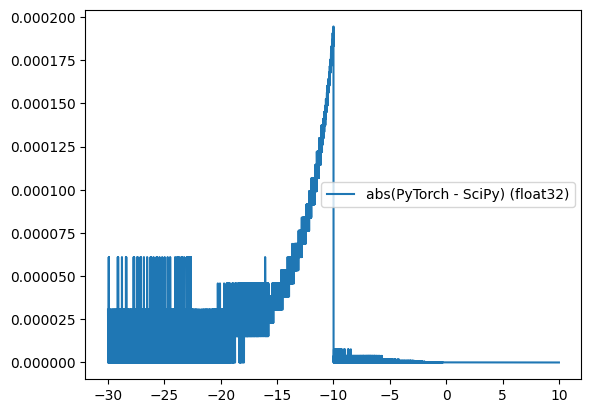

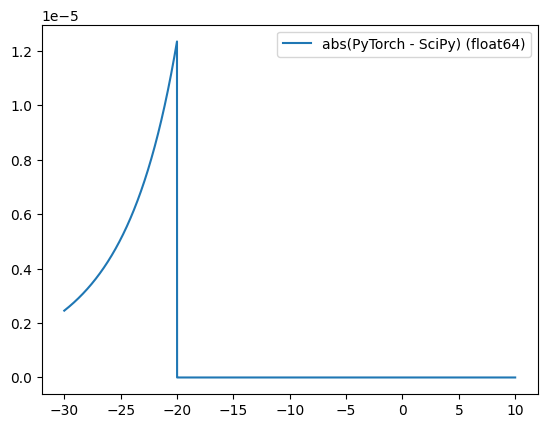

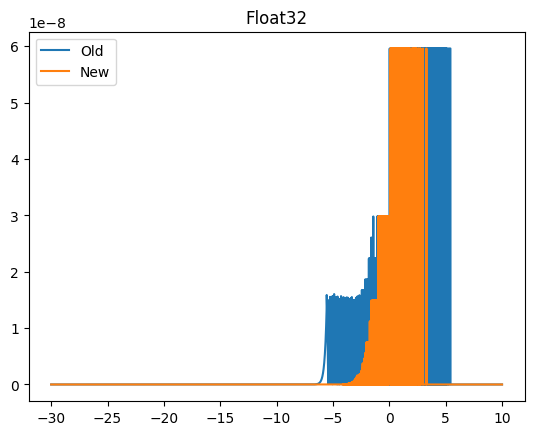

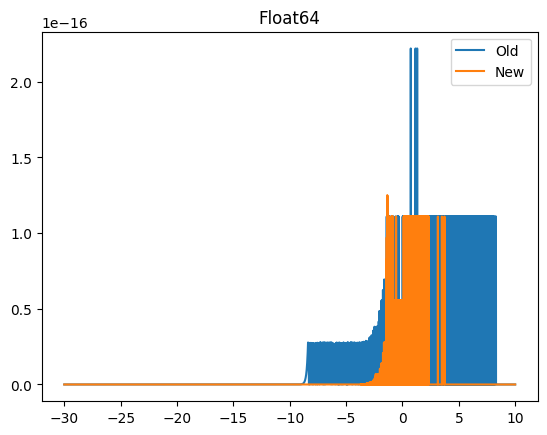

In [4]:
import matplotlib.pyplot as plt
import scipy.special as ss

x = torch.linspace(-30, 10, 40000, dtype=torch.float32)
out = log_ndtr(x)
plt.plot(x.numpy(), abs(out.numpy() - ss.log_ndtr(x.numpy())), label='abs(PyTorch - SciPy) (float32)')
plt.legend()
plt.show()

x = torch.linspace(-30, 10, 40000, dtype=torch.float64)
out = log_ndtr(x)
plt.plot(x.numpy(), abs(out.numpy() - ss.log_ndtr(x.numpy())), label='abs(PyTorch - SciPy) (float64)')
plt.legend()
plt.show()

x = torch.linspace(-30, 10, 40000, dtype=torch.float32)
plt.plot(x.numpy(), abs(torch.distributions.Normal(0, 1).cdf(x).numpy() - ss.ndtr(x.numpy())), label='Old')
plt.plot(x.numpy(), abs(ndtr(x).numpy() - ss.ndtr(x.numpy())), label='New')
plt.title('Float32')
plt.legend()
plt.show()

x = torch.linspace(-30, 10, 40000, dtype=torch.float64)
plt.plot(x.numpy(), abs(torch.distributions.Normal(0, 1).cdf(x).numpy() - ss.ndtr(x.numpy())), label='Old')
plt.plot(x.numpy(), abs(ndtr(x).numpy() - ss.ndtr(x.numpy())), label='New')
plt.title('Float64')
plt.legend()
plt.show()

In [61]:
import torch
import torch.nn as nn
from pl_bolts.models.autoencoders import AE
from fit_classifiers import get_dataset
from utils import WarpDecoder


# Build datasets/loaders
test_set, _ = get_dataset('cifar10', "./dataset", False, 32, True)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=8, shuffle=False,
    num_workers=4, pin_memory=True
)

for x, y in test_loader:
    print(x.shape, y.shape)

    ae = AE(input_height=32)
    ae = ae.from_pretrained('cifar10-resnet18')
    
    warp = WarpDecoder(ae.decoder, latent_dim=256)            # strict (no auto projection)
    z = ae.fc(ae.encoder(x))
    x_prim = warp(z)


    break


Files already downloaded and verified
torch.Size([8, 3, 32, 32]) torch.Size([8])


/tmp/ipykernel_796392/1879754278.py:19: UnderReviewWarning: The feature AE is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  ae = AE(input_height=32)
/home/wang3_z@WMGDS.WMG.WARWICK.AC.UK/miniconda3/envs/WSPR/lib/python3.10/site-packages/pl_bolts/models/autoencoders/basic_ae/basic_ae_module.py:86: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = valid_encoders[enc_type]["enc"](first_conv, maxpool1)
/home/wang3_z@WMGDS.WMG.WARWICK.AC.UK/miniconda3/envs/WSPR/lib/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2061478..2.3501883].


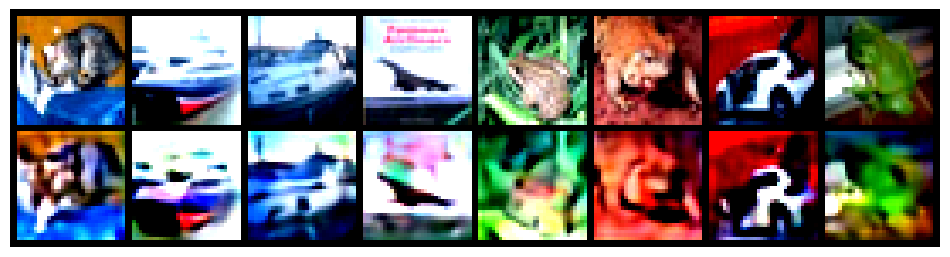

In [62]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
def show_two_batches(batch1, batch2, nrow=None, figsize=(10,5), save_path=None):
    """
    将两个 batch 的图片拼接显示为两行（或保存）。
    
    参数:
        batch1, batch2: torch.Tensor [B, C, H, W], 数值范围 [0,1] 或 [-1,1]
        nrow: 每行展示多少张图。如果为 None，默认取 batch 大小。
        figsize: matplotlib 图大小。
        save_path: 若提供，将保存图片到指定路径。
    """
    assert batch1.shape == batch2.shape, "两个 batch 必须形状一致"
    B = batch1.size(0)
    if nrow is None:
        nrow = B

    # 把 batch 拼在一起 (先 batch1 后 batch2)，形成 2 行
    imgs = torch.cat([batch1, batch2], dim=0)

    # 处理数值范围：若是 [-1,1] -> [0,1]
    if imgs.min() < 0:
        imgs = (imgs + 1) / 2.0

    grid = vutils.make_grid(imgs, nrow=nrow, padding=2)

    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0).cpu())
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

show_two_batches(x, x_prim, nrow=8, figsize=(12,6))    
    